In [1]:
import roslaunch, rospy, time, keyboard
import rospkg as rp
import numpy as np
from std_msgs.msg import Float64
from std_srvs.srv import Empty
from tf2_msgs.msg import TFMessage
from tf.transformations import euler_from_quaternion
from gazebo_msgs.srv import GetLinkState 
import matplotlib.pyplot as plt
from operator import itemgetter
import time,random, string, sys, pickle

pi = 3.1415926

/usr/lib/python2.7/dist-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [2]:
front_setpoint = 45
rear_setpoint = -90

f_topic = '/twolinkman/front_joint_effort_controller/command'                                   #topic name for front joint controller
r_topic = '/twolinkman/rear_joint_effort_controller/command'                                    #topic name for rear joint controller
rcon_launch_path = '/launch/twolinkman_control.launch'
rp = rp.RosPack()
package_path = rp.get_path('twolinkman')

In [3]:
def ref_signal(tau,initialpoint,setpoint,sample_set):
    data = []
    for t in sample_set:
        data.append(initialpoint*np.exp(-t*0.1/tau)+setpoint*(1-np.exp(-t*0.1/tau)))
    return data

In [4]:
#YAML file to update gains
yaml_file = '/home/crm/catkin_ws/src/twolinkman/twolinkman_description/config/twolinkman_control.yaml'
gain_pos = [228, 241, 254,                   #REAR P, I, D
         383, 396, 409]                   #FRONT P, I, D
def gain2str(gain):
    gain = round(gain,3)
    if gain > 9999:
        return -1
    else:
        text = str(gain)
        return text.zfill(8)

def insert_gain(gain,string,pos):
    string = list(string)
    gain_string = gain2str(gain)
    if gain_string == -1:
        return -1
    else:
        string[pos:pos+8] = gain_string
        return ''.join(string)

#To update gains in YAML file
def updateYAML(gain):
    for i in range(6):
        f = open(yaml_file,"r")
        text = f.read()
        f.close()
        string = insert_gain(gain[i],text,gain_pos[i])
        if string == -1:
            return -1
        else:
            f = open(yaml_file,"w")
            f.write(string)
            f.close()
    return 0

In [5]:
def rosservice_client():
    global front_angle_data, rear_angle_data, initial_time
    rospy.wait_for_service('/gazebo/get_link_state')
    model = rospy.ServiceProxy('/gazebo/get_link_state',GetLinkState)
    obj = model("twolinkman::rear_link","base_link")
    x = obj.link_state.pose.orientation.x
    y = obj.link_state.pose.orientation.y
    z = obj.link_state.pose.orientation.z
    w = obj.link_state.pose.orientation.w
    (rear_angle, _, _)= euler_from_quaternion([x,y,z,w])
    obj = model("twolinkman::front_link","rear_link")
    x = obj.link_state.pose.orientation.x
    y = obj.link_state.pose.orientation.y
    z = obj.link_state.pose.orientation.z
    w = obj.link_state.pose.orientation.w
    (front_angle, _, _)= euler_from_quaternion([x,y,z,w])
    front_angle_data.append([np.rad2deg(front_angle),time.time()-initial_time])
    rear_angle_data.append([np.rad2deg(np.arctan2(np.sin(rear_angle+pi),np.cos(rear_angle+pi))),time.time()-initial_time])    #Adjustments to make angular measurements from +ve x axis

In [6]:
def controller():
    #Update setpoints
    global front_setpoint, rear_setpoint, front_joint, rear_joint
    if (abs(front_setpoint) <= 170 and rear_setpoint >= -170 and rear_setpoint <= -10):                        #Check limits of angular positions
        front_joint.pub.publish(np.deg2rad(front_setpoint))
        rear_joint.pub.publish(np.deg2rad(rear_setpoint+90))
    else:
        print('Out of bounds!') 

In [7]:
class Joint:
    def __init__(self,topic,setpoint):
        self.topic = topic
        self.pub = setpoint

In [8]:
gain = []
for i in range(1000):
    gain.append([random.uniform(0,100),random.uniform(0,5),random.uniform(0,3),
                 random.uniform(0,100),random.uniform(0,5),random.uniform(0,3)])
with open('./rawdata.pickle','wb') as f:
    try:
        pickle.dump(gain,f)
    except Exception as e:
      print('Unable to process data from', f, ':', e)
      raise

Starting iteration: 0
... logging to /home/crm/.ros/log/74650ad2-285e-11e9-8c88-d36719a6929d/roslaunch-crm-Inspiron-3543-10085.log
started roslaunch server http://crm-Inspiron-3543:46577/

SUMMARY

PARAMETERS
 * /rosdistro: melodic
 * /rosversion: 1.14.3
 * /twolinkman/front_joint_effort_controller/joint: front_joint
 * /twolinkman/front_joint_effort_controller/pid/d: 449.9
 * /twolinkman/front_joint_effort_controller/pid/i: 435.6
 * /twolinkman/front_joint_effort_controller/pid/p: 421.3
 * /twolinkman/front_joint_effort_controller/type: effort_controller...
 * /twolinkman/joint_state_controller/publish_rate: 10
 * /twolinkman/joint_state_controller/type: joint_state_contr...
 * /twolinkman/rear_joint_effort_controller/joint: rear_joint
 * /twolinkman/rear_joint_effort_controller/pid/d: 279.4
 * /twolinkman/rear_joint_effort_controller/pid/i: 265.1
 * /twolinkman/rear_joint_effort_controller/pid/p: 78.03
 * /twolinkman/rear_joint_effort_controller/type: effort_controller...

NODES
  /t

RLException: pm is not initialized

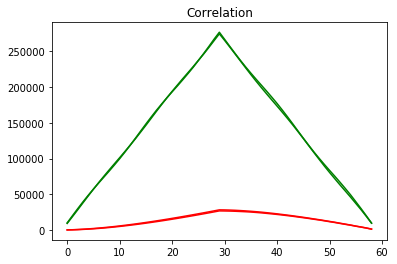

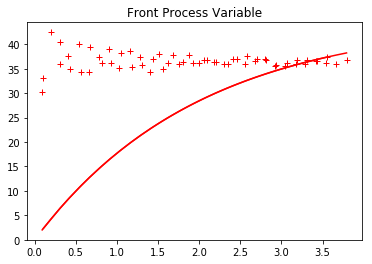

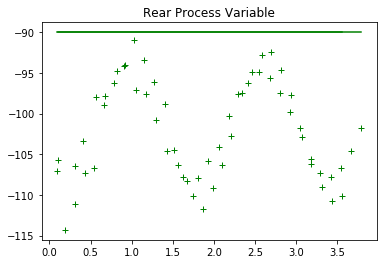

In [9]:
if __name__ == '__main__':
    try:
        ip_file = file('input_rawdata.txt','w')
        op_file = file('output_rawdata.txt','w')
        outter_layer = []
        #Joint instances
        front_joint = Joint(f_topic,None)
        rear_joint = Joint(r_topic,None)
        #new rosnode to publish effort messages from script to ros+gazebo control and latch messages
        #from listeners
        setpointnode = rospy.init_node('SetPoint',anonymous=True)
        front_joint.pub = rospy.topics.Publisher(front_joint.topic,Float64,queue_size=10)
        rear_joint.pub = rospy.topics.Publisher(rear_joint.topic,Float64,queue_size=10)
        for i in range(len(gain)):
            front_joint.pub.publish(0)
            rear_joint.pub.publish(0)
            ip_file.write(str(gain[i]))
            if(updateYAML(gain[i])==-1):
                print("Inapproriate gain value")
                continue
            front_angle_data = []
            rear_angle_data = []
            rospy.wait_for_service('/gazebo/reset_simulation')
            reset_simulation = rospy.ServiceProxy('/gazebo/reset_simulation', Empty)
            reset_simulation()
            print("Starting iteration: "+str(i)+" Gains are: "+str(gain[i]))
            #ROS Control Launch file
            rcon_uuid = roslaunch.rlutil.get_or_generate_uuid(None, False)
            #roslaunch.configure_logging(rcon_uuid)
            rcon_launch = roslaunch.parent.ROSLaunchParent(rcon_uuid, [package_path+rcon_launch_path])      #roslaunch the ros+gazebo controller
            rcon_launch.start()
            time.sleep(2)
            r = rospy.Rate(20)                                #10 Hz publishing rate
            initial_time = time.time()
            #PID loop
            while not rospy.is_shutdown():
                controller()
                r.sleep()
                rosservice_client()
                r.sleep()
                if(len(front_angle_data)>=30):
                    break
            reset_simulation()
            rcon_launch.shutdown()
            tau = 0.2

            front_time_axis = map(itemgetter(1),front_angle_data)
            front_y_axis = map(itemgetter(0),front_angle_data)
            rear_time_axis = map(itemgetter(1),rear_angle_data)
            rear_y_axis = map(itemgetter(0),rear_angle_data)

            front_angle_sp = ref_signal(tau,0,front_setpoint,front_time_axis) 
            rear_angle_sp = ref_signal(tau,-90,rear_setpoint,rear_time_axis)
            front_correlation = np.correlate(front_angle_sp,front_y_axis,'full')
            front_correlation_sp = np.correlate(front_angle_sp,front_angle_sp,'full')
            rear_correlation = np.correlate(rear_angle_sp,rear_y_axis,'full')
            rear_correlation_sp = np.correlate(rear_angle_sp,rear_angle_sp,'full')
            outter_layer.append([front_correlation,rear_correlation,front_correlation_sp,rear_correlation_sp])

            #plt.figure(0)
            #plt.title('Correlation')
            #plt.plot([i for i in range(len(front_correlation))],front_correlation,'r',
            #         [i for i in range(len(rear_correlation))],rear_correlation,'g')
            #plt.figure(1)
            #plt.title('Front Process Variable')
            #plt.plot(front_time_axis,front_angle_sp,'r',front_time_axis,front_y_axis,'r+')
            #plt.figure(2)
            #plt.title('Rear Process Variable')
            #plt.plot(rear_time_axis,rear_angle_sp,'g',rear_time_axis,rear_y_axis,'g+')
        with open('./rawcorrelation.pickle','wb') as f:
            try:
                pickle.dump(outter_layer,f)
            except Exception as e:
              print('Unable to process data from', f, ':', e)
              raise
            
    except (KeyboardInterrupt,SystemExit):
        reset_simulation()
        rcon_launch.shutdown()
        exit_ = True
        raise Exception('Closing program...')

In [22]:
import pickle
with open('./rawdata.pickle','rb') as f:
    try:
        outter_layer = pickle.load(f)
    except Exception as e:
      print('Unable to process data from', f, ':', e)
      raise
print(outter_layer[2][3])

IndexError: list index out of range